In [269]:

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import math

import gym
from frozen_lake_utils import *

import warnings
warnings.filterwarnings('ignore')
from time import time

In [31]:
env = gym.make('MountainCar-v0')

In [338]:
env.high

array([0.6 , 0.07], dtype=float32)

In [340]:
v

array([-0.07, -0.05, -0.04, -0.02, -0.01,  0.01,  0.02,  0.04,  0.05,
        0.07])

In [339]:
p

array([-1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6])

In [174]:
def id_to_state(idx,p,v,size=10):
    p_id = idx//size
    v_id = idx%size
    return [p[p_id],v[v_id]]

def state_to_index(env, state, p, v, state_size):
    position, velocity = state

    idx1 = np.searchsorted(p, position)
    idx2 = np.searchsorted(v, velocity)
    
    return idx1*state_size + idx2


def (state_size=20):
    env = gym.make('MountainCar-v0')

    nA = env.action_space.n
    nS = state_size**2

    minimum_states_value = env.low
    maximum_states_value = env.high

    position_states = np.linspace(minimum_states_value[0], maximum_states_value[0], state_size).round(decimals=2)
    velocity_states = np.linspace(minimum_states_value[1], maximum_states_value[1], state_size).round(decimals=2)


    P = {s: {a: [] for a in range(nA)} for s in range(nS)}
    for i in range(state_size):
        for j in range(state_size):
            for action in range(nA):
                # 2D to 1D
                state = to_s(i, j, state_size)

                position, velocity = position_states[i], velocity_states[j]
                velocity += (action - 1) * env.force + math.cos(3 * position) * (-env.gravity)
                velocity = np.clip(velocity, -env.max_speed, env.max_speed)
                new_velocity = np.argmin([np.abs(x-velocity) for x in velocity_states])

                position += velocity
                position = np.clip(position, env.min_position, env.max_position)
                new_position = np.argmin([np.abs(x-position) for x in position_states])

                reward = np.abs(0.01*(velocity/env.max_speed))
                done = False

                if position >= env.goal_position:
                    reward = 1
                    done = True
                P[state][action].append((1, to_s(new_position, new_velocity, state_size), reward, done))

    env.nA = nA
    env.nS = nS
    env.P = P
    return env, position_states, velocity_states

In [326]:
def plot_deltas_time(deltas, times, problem="Frozen Lake"):

    fig, ax = plt.subplots(1, 2, figsize=(18,5))
    ax[0].set_title("Delta V "+problem)
    ax[0].set_ylabel('delta V')
    ax[0].set_xlabel('iteration')
    ax[0].plot(np.arange(len(deltas)), deltas)
    ax[1].set_title("Computational Time "+problem)
    ax[1].set_ylabel('time')
    ax[1].set_xlabel('iteration')
    ax[1].plot(np.arange(len(times)), times)
    plt.show()
        
def plot_scores_time(scores, times, problem="Frozen Lake"):

    fig, ax = plt.subplots(1, 2, figsize=(18,5))
    ax[0].set_title("Episode scores "+problem)
    ax[0].set_ylabel('score')
    ax[0].set_xlabel('episode')
    ax[0].plot(np.arange(len(scores)), scores)
    ax[1].set_title("Computational Time "+problem)
    ax[1].set_ylabel('time')
    ax[1].set_xlabel('episode')
    ax[1].plot(np.arange(len(times)), times)
    plt.show()
    
def plot_val_grid(env, V, problem='Mountain car'):
    actions_state = np.zeros((10,10))
    for i in range(100):
        actions_state[i//10,i%10] = np.argmax(V[i])
    fig, ax = plt.subplots(1, 1, figsize=(18,9))
    ax.set_title("Action grid "+problem)
    sns.heatmap(actions_state, annot=False, fmt='.2f', linewidths=.4, cmap="YlGnBu")
    plt.show()

        
def plot_policy_map(policy, V, rows, columns, problem='Frozen Lake'):

    policy_labels = np.empty([rows, columns], dtype='<U32')
    for row in range(rows):
        for col in range(columns):
            state = row * columns + col
            policy_labels[row, col] += 'L' * (policy[state] == 0)
            policy_labels[row, col] += 'D' * (policy[state] == 1)
            policy_labels[row, col] += 'R' * (policy[state] == 2)
            policy_labels[row, col] += 'U' * (policy[state] == 3)

    fig, ax = plt.subplots(1, 1, figsize=(18,9))
    ax.set_title("Best action grid "+problem)
    sns.heatmap(V.reshape(rows, columns), annot=policy_labels, fmt='', linewidths=.4, cmap="YlGnBu")
    plt.show()

    
def get_actions(env, gamma, state, v):
    A = np.zeros(env.nA)
    for action in range(env.nA):
        for p, next_state, reward, done in env.P[state][action]:
            A[action] += p * (reward + gamma * v[next_state])
    return A

def value_iteration(env, discount=0.99, max_iterations=1000, threshold_delta=1e-03, problem='Mountain car Value Iteration'):
    
    V = np.zeros(env.nS)
    deltas = []
    times = []

    start_it_time = time()
    for _ in range(max_iterations):
        delta = 0
        reward = 0
    
        for state in range(env.nS):
            previous_V = V[state]
            A = get_actions(env, discount, state, V)

            # Value Iteration: update state value using the Bellman optimality equation
            best_action_value = np.max(A)
            V[state] = best_action_value

            # threshold is the highest delta so far
            delta = max(delta, np.abs(best_action_value - previous_V))

            # Best action
            best_action = np.argmax(V)

            reward += best_action_value

        deltas.append(delta)
        times.append(time()-start_it_time)
        
        if delta < threshold_delta:
            break;
    print('took %s iteration to converge'%(str(_)))
    optimal_policy  = np.zeros((env.nS, env.nA))
    optimal_actions  = np.zeros(env.nS).astype(int)
    
    for state in range(env.nS):
        A = get_actions(env, discount, state, V)
        best_action = np.argmax(A)

        optimal_policy[state, best_action] = 1.0
        optimal_actions[state] = best_action
        
    plot_val_grid(env, optimal_policy, problem)
    plot_deltas_time(deltas, times, problem)

    return V, optimal_policy

def policy_iteration(env, discount_factor=0.995, max_iterations_hl=10, max_iterations_ll=1000,threshold_delta = 1e-3, problem = 'Mountain car'):
    iteration = 0
    continue_improve = True
    
    V = np.zeros(env.nS)
    policy = np.ones([env.nS, env.nA]) / env.nA 
    policy_actions = np.zeros(env.nS).astype(int)

    final_deltas = []
    final_times = []
    start_time = time()

    while iteration <= max_iterations_hl and continue_improve:
        deltas = []
        times = []
        for _ in tqdm(range(max_iterations_ll)):
            delta = 0
            reward = 0
            for state in range(env.nS):
                previous_V = V[state]

                # Update V
                Q_current_state = get_actions(env, discount_factor, state, V)
                V[state] = 0.
                for action in range(env.nA):
                    V[state] += policy[state, action] * Q_current_state[action]

                delta = max(delta, np.abs(V[state] - previous_V))

                reward += np.max(Q_current_state)

            deltas.append(delta)
            times.append(time() - start_time)


            if delta < threshold_delta:
                break;

        continue_improve = False

        for state in range(env.nS):
            # New best action
            previous_best_action = np.argmax(policy[state])
            Q_current_state = get_actions(env, discount_factor, state, V)
            new_best_action = np.argmax(Q_current_state.round(decimals=4))

            # If policy has improved
            if previous_best_action != new_best_action:
                continue_improve = True

            # New policies
            policy[state] = np.eye(env.nA)[new_best_action]
            policy_actions[state] = new_best_action

        final_deltas += deltas
        final_times += times
        iteration += 1

    print('took %s iteration to converge'%(len(final_times)))
    plot_deltas_time(final_deltas, final_times, problem)
    plot_val_grid(env, policy, problem)


    return V, policy

def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
    
        while done != True:   
            # Render environment for last five episodes
            if i >= (episodes - 20):
                env.render()
                
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            #Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
            
    env.close()
    
    return ave_reward_list


In [256]:
env, p, v = disc_env(10)

took 2062 iteration to converge
(100, 3)


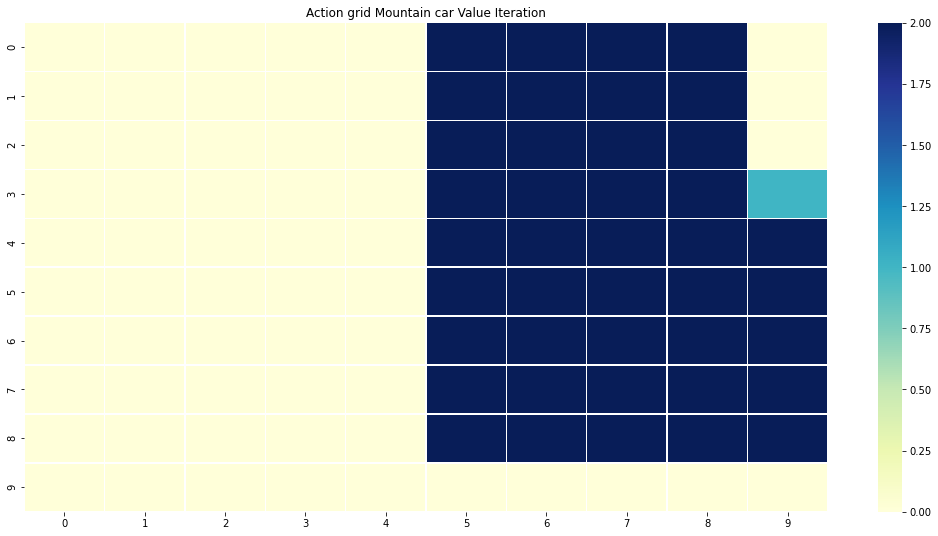

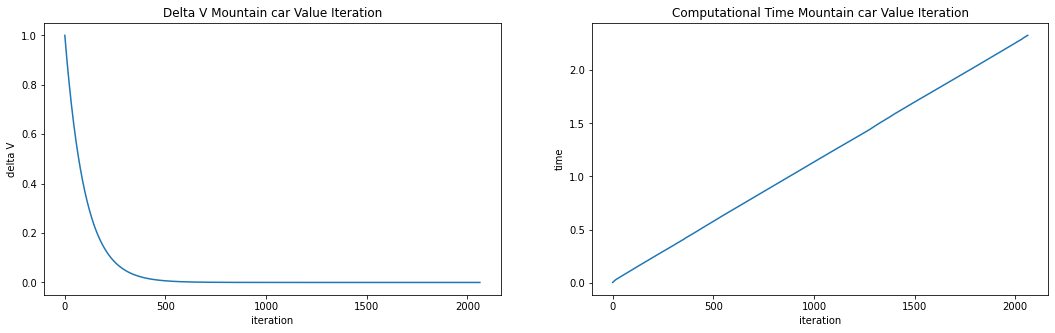

In [325]:
V ,policy = value_iteration(env, threshold_delta=1e-9, max_iterations= 5000)

 47%|████▋     | 2368/5000 [00:03<00:03, 723.02it/s]


took 6505 iteration to converge


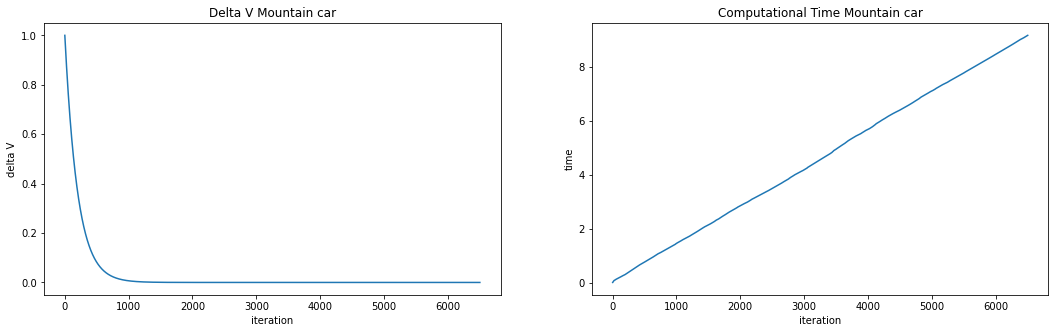

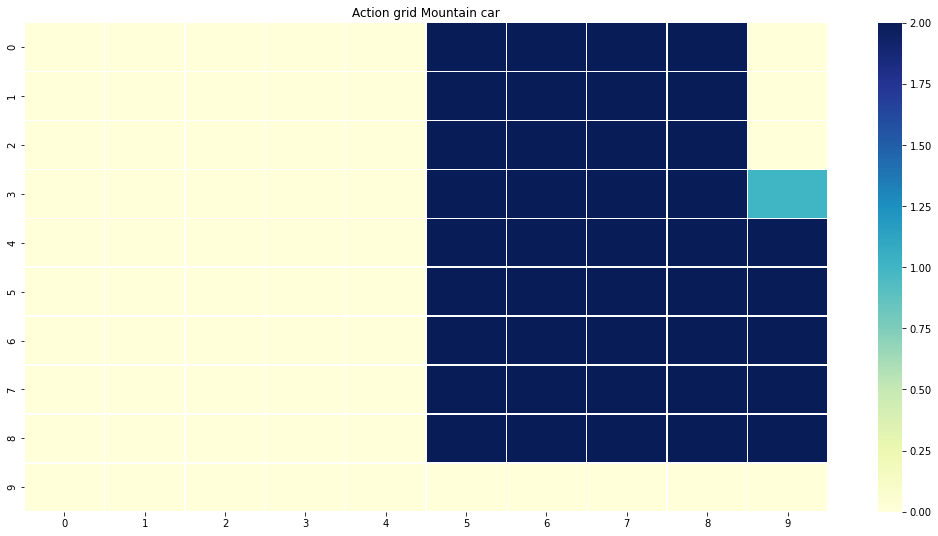

In [327]:
V ,policy_pi = policy_iteration(env, threshold_delta=1e-9, max_iterations_ll=5000, max_iterations_hl=1000)

In [285]:
def play(runs=100, policy=None):
    winrate = 0
    for _ in range(runs):
        env.reset()
        action = np.argmax(policy[state_to_index(env, env.reset(), position_states, velocity_states, state_size)])
        for i in range(200):
            state,r,done,_ = env.step(action)
            if done and i!=199:
                winrate +=1
                break
            action = np.argmax(policy[state_to_index(env, state, position_states, velocity_states, state_size)])
    print('winrate percentage %s'%(winrate/runs))

In [286]:
play(policy=policy)

winrate percentage 0.55


In [295]:
play(policy=policy_pi)

winrate percentage 0.45


In [341]:
start = time()
rewards = QLearning(env, 0.2, 0.9, 0.8, 0, 5000)
print('runtime:',time()-start)

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -200.0
Episode 1000 Average Reward: -200.0
Episode 1100 Average Reward: -200.0
Episode 1200 Average Reward: -200.0
Episode 1300 Average Reward: -200.0
Episode 1400 Average Reward: -200.0
Episode 1500 Average Reward: -200.0
Episode 1600 Average Reward: -200.0
Episode 1700 Average Reward: -200.0
Episode 1800 Average Reward: -200.0
Episode 1900 Average Reward: -200.0
Episode 2000 Average Reward: -200.0
Episode 2100 Average Reward: -200.0
Episode 2200 Average Reward: -200.0
Episode 2300 Average Reward: -200.0
Episode 2400 Average Reward: -200.0
Episode 2500 Average Reward: -200.0
Episode 2600 Average Reward: -200.0
Episode 2700 Average Reward: -200.0
Episode 2800 Average Reward: -200.0
E

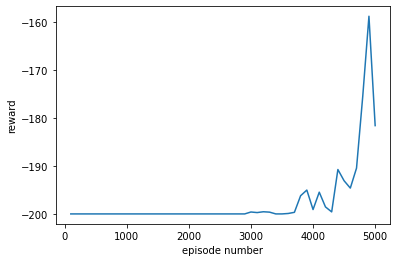

In [336]:
plt.plot(list(range(100,5100,100)),rewards)
plt.xlabel('episode number')
plt.ylabel('reward')
plt.show()